In [1]:
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time
import warnings

import scipy.ndimage.filters
import scipy.stats as stats

from IPython.display import display, clear_output

import nelpy as nel
import nelpy.plotting as npl

from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

from nelpy import hmmutils
from nelpy.decoding import k_fold_cross_validation
from nelpy.decoding import decode1D

# Set default figure aesthetics
npl.setup(font_scale=1.0)

%matplotlib inline

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [2]:
import gcsfs
import pandas as pd

fs = gcsfs.GCSFileSystem(project='polar-program-784', token='cloud')
print(fs.ls('kemerelab-data/diba'))

with fs.open('kemerelab-data/diba/gor01vvp01pin01-metadata.h5', 'rb') as fid:
    with pd.HDFStore('gor01vvp01pin01-metadata.h5', mode="r", driver="H5FD_CORE",
            driver_core_backing_store=0,
            driver_core_image=fid.read()
            ) as store:
        df = store['Session_Metadata']
        df2 = store['Subset_Metadata']


['kemerelab-data/diba/', 'kemerelab-data/diba/gor01vvp01-metadata.h5', 'kemerelab-data/diba/gor01vvp01_processed_speed.nel', 'kemerelab-data/diba/gor01vvp01pin01-metadata.h5', 'kemerelab-data/diba/gor01vvp01pin01_processed_speed.nel']


In [3]:
# %%timeit # beware - this will run it 7 times to get a time! 36 s for 1.4 GB file

with fs.open('kemerelab-data/diba/gor01vvp01pin01_processed_speed.nel', 'rb') as fid:
    jar = nel.load_pkl('',fileobj=fid) # currently requires a specific nelpy branch

exp_data = jar.exp_data
aux_data = jar.aux_data
del jar

# Draw real place fields

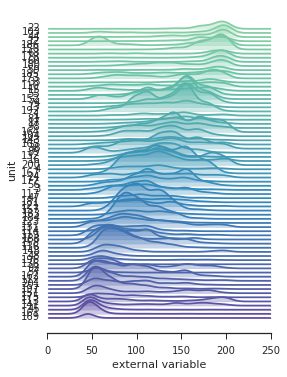

In [38]:
# session_time, segment = '1-22-43', 'long'
# session_time, segment = '16-40-19', 'short'

session_time, segment = '1-22-43', 'short'

PBEs = aux_data[session_time][segment]['PBEs']
st_run = aux_data[session_time][segment]['st_run']
tc = aux_data[session_time][segment]['tc']
tc_placecells = aux_data[session_time][segment]['tc_placecells']

#####################################################################

NUM_COLORS = tc_placecells.n_units * 4

cm = plt.get_cmap('Spectral_r')
clist = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
clist = np.roll(clist, 0, axis=0)

npl.set_palette(clist)

with npl.FigureManager(show=True, figsize=(4,6)) as (fig, ax):
    ax = npl.plot_tuning_curves1D(tc_placecells.smooth(sigma=3), pad=2.5);
    ax.set_xlim(0,250)

# Compute virtual tuning curves...

In [19]:
# session_time, segment = ('16-40-19', 'short') # example session

num_states = 30 # number of states for PBE HMM
ds = 0.02 # 20 ms bin size for PBEs
ds_run = 0.1
ds_50ms = 0.05
min_tc_duration = 0 # mininmum observation time in seconds, before a bin contributes to the tuning curve
sigma_tc = 4 # 4 cm smoothing on tuning curves

vtcs = []

k_folds = 5

st = aux_data[session_time][segment]['st_run']
PBEs = aux_data[session_time][segment]['PBEs']

X = [ii for ii in range(PBEs.n_epochs)]

description = (session_time, segment)

print("session: {}".format(description))

st_no_ripple = st[~exp_data[session_time]['mua_epochs']]

pos = exp_data[session_time]['pos1d'] # should this be pos1d?

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_no_ripple = st_no_ripple.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

bst = bst_no_ripple

ext_nx=124
x0=0; xl=310;

xx_left = np.linspace(x0,xl,ext_nx+1)
xx_mid = np.linspace(x0,xl,ext_nx+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2

for kk, (training, validation) in enumerate(k_fold_cross_validation(X, k=k_folds)):     
    print('  fold {}/{}'.format(kk+1, k_folds))

    PBEs_train = PBEs[training]
    PBEs_test = PBEs[validation]

    # train HMM on all training PBEs
    hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
    hmm.fit(PBEs_train)

    # reorder states according to transmat ordering
    transmat_order = hmm.get_state_order('transmat')
    hmm.reorder_states(transmat_order)

    # compute spatial info on non-shuffled data:
    xpos = pos.asarray(at=bst.centers).yvals

    ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
    ext_x = ext_x.astype(float)
    ext_x[ext_x==0] = np.nan
    ext_x[ext_x>=ext_nx] = np.nan

    extern = hmm.fit_ext(X=bst_no_ripple, ext=ext_x, n_extern=ext_nx)

    vtc = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
    vtc = vtc.smooth(sigma=sigma_tc)
    
    vtc.reorder_units(inplace=True)
    
    vtcs.append(vtc)
    

session: ('16-40-19', 'short')
  fold 1/5
  fold 2/5
  fold 3/5
  fold 4/5
  fold 5/5


In [6]:
NUM_COLORS = vtc.n_units + 2

cm = plt.get_cmap('viridis')
clist = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

npl.set_palette(clist)

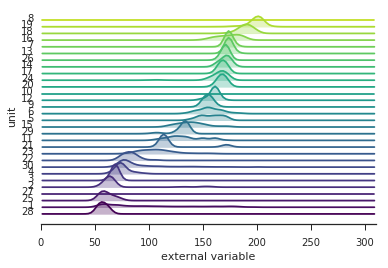

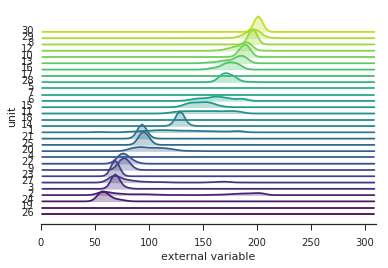

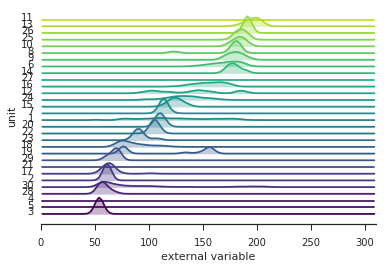

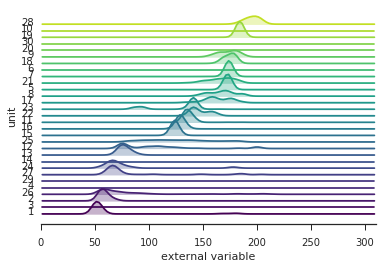

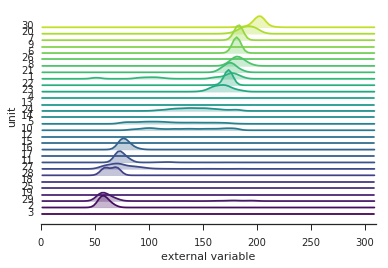

In [7]:
for vtc in vtcs:
    npl.plot_tuning_curves1D(vtc, pad=0.1)
    plt.show()

In [8]:
# train HMM on all training PBEs
hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
hmm.fit(PBEs)

# reorder states according to transmat ordering
transmat_order = hmm.get_state_order('transmat')
hmm.reorder_states(transmat_order)

# compute spatial info on non-shuffled data:
xpos = pos.asarray(at=bst.centers).yvals

ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
ext_x = ext_x.astype(float)
ext_x[ext_x==0] = np.nan
ext_x[ext_x>=ext_nx] = np.nan

extern = hmm.fit_ext(X=bst_no_ripple, ext=ext_x, n_extern=ext_nx)

vtc_ = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
vtc_ = vtc_.smooth(sigma=sigma_tc)

vtc_.reorder_units(inplace=True)

# normalize position distributions for each state (FFB! This will affect decoding! But it's not the only "correct" way to normalize!)
vtc_._ratemap = (vtc_.ratemap.T / vtc_.ratemap.sum(axis=1)).T

(0, 250)

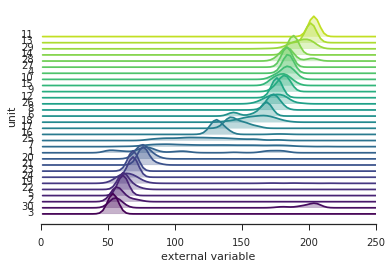

In [9]:
ax = npl.plot_tuning_curves1D(vtc_, pad=0.075)
ax.set_xlim(0, 250)
#npl.savefig('vtc_distr', formats=['pdf', 'png', 'svg'])

(0, 250)

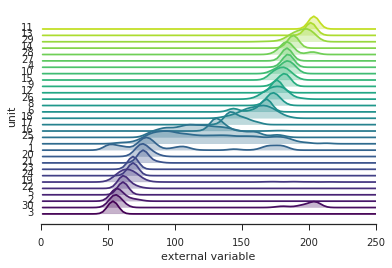

In [10]:
ax = npl.plot_tuning_curves1D(vtc_, normalize=True, pad=0.5)
ax.set_xlim(0, 250)
#npl.savefig('vtc_normalized', formats=['pdf', 'png', 'svg'])

(0, 250)

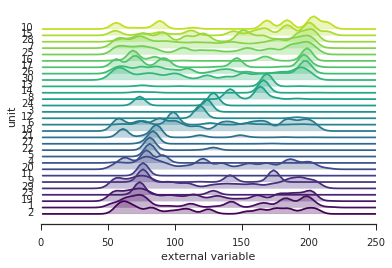

In [11]:
shuffled_pos = copy.deepcopy(pos)

# shuffled_pos._ydata = shuffled_pos._ydata[:, np.random.permutation(pos.n_samples)]

# shuffled_pos._interp = None # necessary so that new interpolant is used, and not old one, before shuffle
xpos = shuffled_pos.asarray(at=bst.centers).yvals
xpos = xpos[np.random.permutation(len(xpos))]

ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
ext_x = ext_x.astype(float)
ext_x[ext_x==0] = np.nan
ext_x[ext_x>=ext_nx] = np.nan

extern = hmm.fit_ext(X=bst_no_ripple, ext=ext_x, n_extern=ext_nx)
# transform into ratemap shape

vtc_shfl = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
vtc_shfl = vtc_shfl.smooth(sigma=sigma_tc)

vtc_shfl.reorder_units(inplace=True)

# normalize position distributions for each state (FFB! This will affect decoding! But it's not the only "correct" way to normalize!)
vtc_shfl._ratemap = (vtc_shfl.ratemap.T / vtc_shfl.ratemap.sum(axis=1)).T

ax = npl.plot_tuning_curves1D(vtc_shfl, normalize=True, pad=0.5)
ax.set_xlim(0, 250)

# results[(session_time, segment)]['shuffled'].extend(vtc.spatial_information().tolist())

# npl.savefig('vtc_shuffled', formats=['pdf', 'png', 'svg'])

(0, 250)

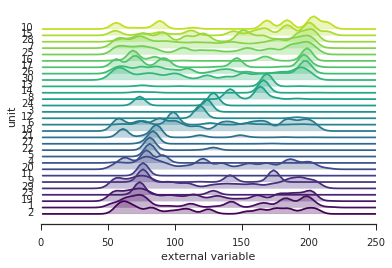

In [12]:
ax = npl.plot_tuning_curves1D(vtc_shfl, normalize=True, pad=0.5)
ax.set_xlim(0, 250)
# npl.savefig('vtc_shuffled3', formats=['pdf', 'png', 'svg'])

## Calculate Run HMMs

In [13]:
ds_run = 0.1 # 500 ms
ds_50ms = 0.05
s = np.argwhere([segment == segment_label for segment_label in df[df.time==session_time]['segment_labels'].values.tolist()[0]])
st_run = exp_data[session_time]['spikes'][s][exp_data[session_time]['run_epochs']]

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

sigma = 6.2 # smoothing std dev in cm
tc_ = nel.TuningCurve1D(bst=bst_run, extern=exp_data[session_time]['pos1d'], n_extern=100, extmin=0, extmax=310, sigma=sigma, min_duration=0)
tc_ = tc.reorder_units()

In [14]:
# OK - let's think about what we want to do:

# Big question - what is the latent space that describes hippocampal activity?
#  (1) - what does that latent space look like?
#      - transition matrix and firing rate matrix
#      - sparsity, compared with shuffles?
#      - cross-validated virtual tuning curves
#  (2) - we can learn models on both place cell activity and PBEs
#      - are they equivalent?
#       : latent space looks qualitatively similar
#      - how do they differ?
#       : cross-validated likelihood (goodness-of-fit) is more different than shuffles?
#       : is there something to be said about scoring? maybe PBE-in-place cell better than
#          place cell in PBE
#  (3) - can we see replay?


# (0) replicate cross-modal scoring
#    - cross-validated self scoring (train model on subsets, test on the rest)
#    - cross-modal scoring (train model on whole set)
#    - have to deal with sequence length, but can compare by sequence
# 
# (1) cross-validation training curves comparing to shuffles?
#    - this could be the way Kamran suggested (just shuffling the test set)
#    - this could also be the way Etienne suggested (shuffling all the data, then training as usual)
#
# (2) generate sparsity data for transition and rate matrices
#
# (3) Is there a way to think about mutual information??? I think it would be hard, because I think 
#     the operant question would be MI(spikes | position) and MI(spikes | latent state)

### Calculate virtual tuning curves for RUN HMM and compare with PBE

In [33]:
# session_time, segment = ('16-40-19', 'short') # example session

num_states = 30 # number of states for PBE HMM
ds = 0.02 # 20 ms bin size for PBEs
min_tc_duration = 0 # mininmum observation time in seconds, before a bin contributes to the tuning curve
sigma_tc = 4 # 4 cm smoothing on tuning curves

description = (session_time, segment)
print("session: {}".format(description))

s = np.argwhere([segment == segment_label for segment_label in df[df.time==session_time]['segment_labels'].values.tolist()[0]])
st_run = exp_data[session_time]['spikes'][s][exp_data[session_time]['run_epochs']]

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)
bst = bst_run


pos = exp_data[session_time]['pos1d'] # should this be pos1d?

ext_nx=124
x0=0; xl=310;

xx_left = np.linspace(x0,xl,ext_nx+1)
xx_mid = np.linspace(x0,xl,ext_nx+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2

#########################################################
# Generate an HMM trained on all PBEs 
PBEs = aux_data[session_time][segment]['PBEs']
pbe_hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
pbe_hmm.fit(PBEs)
transmat_order = hmm.get_state_order('transmat')
pbe_hmm.reorder_states(transmat_order)

xpos = pos.asarray(at=bst_run.centers).yvals

ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
ext_x = ext_x.astype(float)
ext_x[ext_x==0] = np.nan
ext_x[ext_x>=ext_nx] = np.nan

extern = pbe_hmm.fit_ext(X=bst_run, ext=ext_x, n_extern=ext_nx)

pbe_vtc = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
pbe_vtc = pbe_vtc.smooth(sigma=sigma_tc)
pbe_vtc.reorder_units(inplace=True)
#########################################################

k_folds = 3
vtcs_run = []
X = list(range(bst_run.n_epochs))

for kk, (training, validation) in enumerate(k_fold_cross_validation(X, k=k_folds)):     
    print('  fold {}/{}'.format(kk+1, k_folds))

    RunSeqs_train = bst[training]
    RunSeqs_test = bst[validation]

    # train HMM on all training PBEs
    hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
    hmm.fit(RunSeqs_train)

    # reorder states according to transmat ordering
    transmat_order = hmm.get_state_order('transmat')
    hmm.reorder_states(transmat_order)

    # compute spatial info on non-shuffled data:
    xpos = pos.asarray(at=RunSeqs_test.centers).yvals

    ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
    ext_x = ext_x.astype(float)
    ext_x[ext_x==0] = np.nan
    ext_x[ext_x>=ext_nx] = np.nan

    extern = hmm.fit_ext(X=RunSeqs_test, ext=ext_x, n_extern=ext_nx)

    vtc = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
    vtc = vtc.smooth(sigma=sigma_tc)
    
    vtc.reorder_units(inplace=True)
    
    vtcs_run.append(vtc)
    

session: ('1-22-43', 'long')
  fold 1/3
  fold 2/3
  fold 3/3


In [21]:
vtc

<TuningCurve1D at 0x7f3add272908> with shape (30, 124)

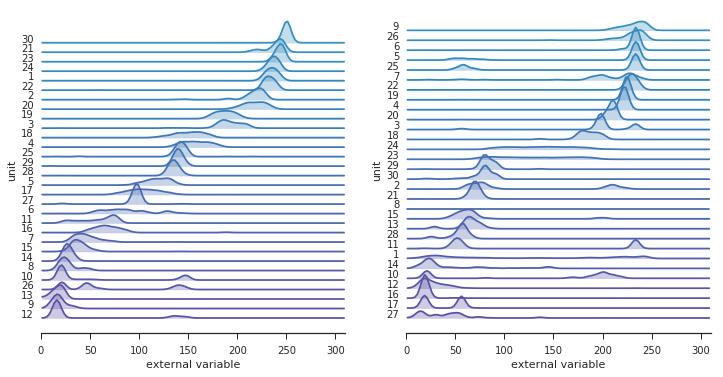

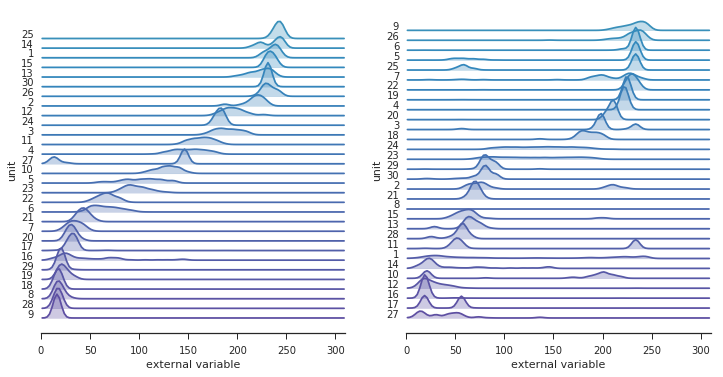

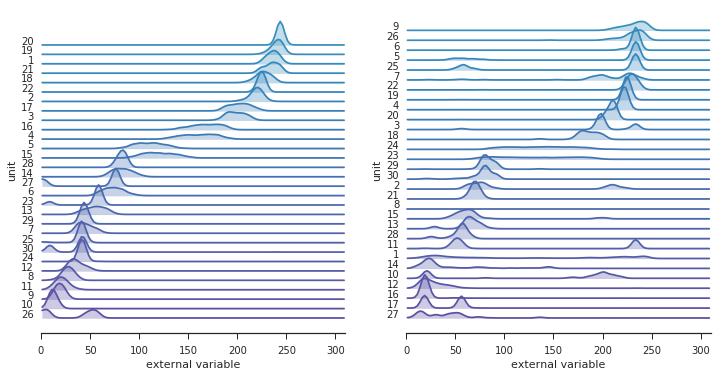

In [34]:
for vtc in vtcs_run:
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    npl.plot_tuning_curves1D(vtc, pad=0.1, ax=axs[0])
    npl.plot_tuning_curves1D(pbe_vtc, pad=0.1, ax=axs[1])
    plt.show()

In [ ]:
# set criteria for units used in decoding
min_peakfiringrate = 1 # Hz
max_avgfiringrate = 5 # Hz
peak_to_mean_ratio_threshold = 0 # peak firing rate should be greater than 3.5 times mean firing rate

# unimodal_cells = find_unimodal_tuningcurves1D(smoothed_rate, peakthresh=0.5)

# enforce minimum peak firing rate
unit_ids_to_keep = set(np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.max(axis=1)>min_peakfiringrate).squeeze().tolist()])
# enforce maximum average firing rate
unit_ids_to_keep = unit_ids_to_keep.intersection(set( np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.mean(axis=1)<max_avgfiringrate).squeeze().tolist()]   ))

# enforce peak to mean firing ratio
peak_firing_rates = tc.max(axis=1)
mean_firing_rates = tc.mean(axis=1)
ratio = peak_firing_rates/mean_firing_rates
unit_ids_to_keep = unit_ids_to_keep.intersection(set(np.asanyarray(tc.unit_ids)[np.argwhere(ratio>=peak_to_mean_ratio_threshold).squeeze().tolist()]))

# finally, convert remaining units into a list of indices
unit_ids_to_keep = list(unit_ids_to_keep)

# modify spike trains and ratemap to only include those units that passed all the criteria
sta_placecells = exp_data[session_time]['spikes']._unit_subset(unit_ids_to_keep)

tc_placecells = tc._unit_subset(unit_ids_to_keep)

# reorder cells by peak firing location on track (this is nice for visualization, but doesn't affect decoding)
tc_placecells.reorder_units(inplace=True)

sta_placecells.reorder_units_by_ids(tc_placecells.unit_ids, inplace=True)

# with plt.xkcd():
with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, nrows=1, ncols=3, figsize=(16,4)) as (fig, axes):
        npl.utils.skip_if_no_output(fig)
        ax0, ax1, ax2 = axes

        npl.plot_tuning_curves1D(tc_placecells.smooth(sigma=3), ax=ax0, pad=5.5);
        npl.plot_tuning_curves1D(tc_placecells.smooth(sigma=3), ax=ax1, normalize=True, pad=0.9);
        npl.plot_tuning_curves1D(tc_placecells.smooth(sigma=3), ax=ax2, pad=0);

        for ax in axes:
            ax.set_xlabel('position [cm]')
        npl.utils.xticks_interval(25, *axes)
        npl.utils.yticks_interval(5, ax2)
        npl.add_simple_scalebar("10 Hz", ax=ax0, xy=(10, 57), length=10, orientation='v', rotation_text='h', size=14)
#         npl.add_simple_scalebar("5 Hz", ax=ax1, xy=(10, 17.5), length=5, orientation='v', rotation_text='h', size=14)
        ax0.set_title('True firing rates', size=12)
        ax1.set_title('Normalized firing rates', size=12)
        ax2.set_title('Collapsed units (pad=0)', size=12)